# ROI Presence All clusters Histogram

Plots for clustered masks how often a cell was present in each recording (histogram)

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import vr2p
import gcsfs, pickle
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from vr2p import styles
import yaml
from multiday_suite2p.transform import cluster_cell_masks
import pickle
import math

# Main Parameters

In [2]:
animals = ['A4','A5','A7','B2','B3','B4','B5','C1','D1','F1', 'F5']
bin_size = 10
# cluster Settings
cluster_settings = """
criterion: "distance" # criterion used for clustering
threshold: 0.75 # Threshold used for clustering algorithm
min_sessions_perc: 0 #Exclude masks not present for this percentage of sessions (0-100).
min_perc: 50 #Create template based on pixels detected in X% of sesions.
step_sizes: [200,200] # clustering happens in these sizes blocks across the plane (for memory reasons)
bin_size: 50 # Look for masks around center+bin-size to avoid edge cases
min_distance: 20 # only masks with centers within this pixel radius of each other are considered for clustering.
min_size_non_overlap: 25 # minimum size of template mask in pixels.
  """
cluster_settings = yaml.safe_load(cluster_settings)
cluster_settings['min_sessions_perc'] = 0 # include all.

# Run clustering for all animals with adjusted settings

In [ ]:
if True:
    # Collect data.
    def run_clustering(animal, cluster_settings):
        # get vr2p data
        data = vr2p.ExperimentData(f'/.../Set A/Tyche-{animal}-SetA.zarr')
        im_size = data.images.registered[0]['mean_img'].shape
        # registration data.
        fs = gcsfs.GCSFileSystem(project='sprustonlab-meso')
        with fs.open(f'/.../registration/register-Tyche-{animal}.pkl', 'rb') as handle:
            deforms, trans_images,trans_masks, trans_label_im = pickle.load(handle)
        #  assert that number of sessions align.
        assert len(trans_masks)== len(data.images.registered) ,'Number of sessions in data and stored registration do not match'
        # cluster and create template masks.
        matched_cells, matched_im = cluster_cell_masks(trans_masks, im_size, cluster_settings,verbose=False)
        return {'animal':animal,'num_sessions': len(matched_im), 'matched_cells':matched_cells}
    matched_info = [ run_clustering(animal, cluster_settings) for animal in tqdm(animals) ] 
    # store.
    with open('matched_info.pkl', 'wb') as f:
        pickle.dump(matched_info, f)

  0%|          | 0/11 [00:00<?, ?it/s]

# Load

# Collect hist data.

Note if animal does not have enough sessions to get data in one bin then it is ignored for that bin.

In [4]:
result = []
for info in matched_info:
    # get percentages
    perc_present = np.array([ (len(cluster)/info['num_sessions'])*100 for cluster in info['matched_cells']])
    hist_data,bins = np.histogram(perc_present,np.arange(0,100+bin_size,bin_size))
    assert (len(info['matched_cells']) == len(perc_present)) & (len(info['matched_cells']) == sum(hist_data)),'number of cells did not match'
    hist_data = hist_data.astype(float)
    hist_data /= np.array(len(info['matched_cells'])).astype(float)
    hist_data*=100
    assert round(sum(hist_data),2)==100, 'histogram data did not sum to 100'
    hist_data[hist_data==0]=None
    result.append(hist_data)
result = np.array(result)
result_m = np.nanmean(result,axis=0)
result_std = np.nanstd(result,axis=0)
result_sem = result_std/math.sqrt(len(animals))
print(result_m)
print(result_std)

[14.11358248 16.44707112 12.25284102 12.45731703  9.64945898  9.54444485
 11.20545923  7.72584773 11.56809695 21.88072936]
[1.0881507  5.00208004 3.08874571 3.28513453 3.14263452 3.35890913
 2.30385109 2.4341759  3.25571745 5.26470261]


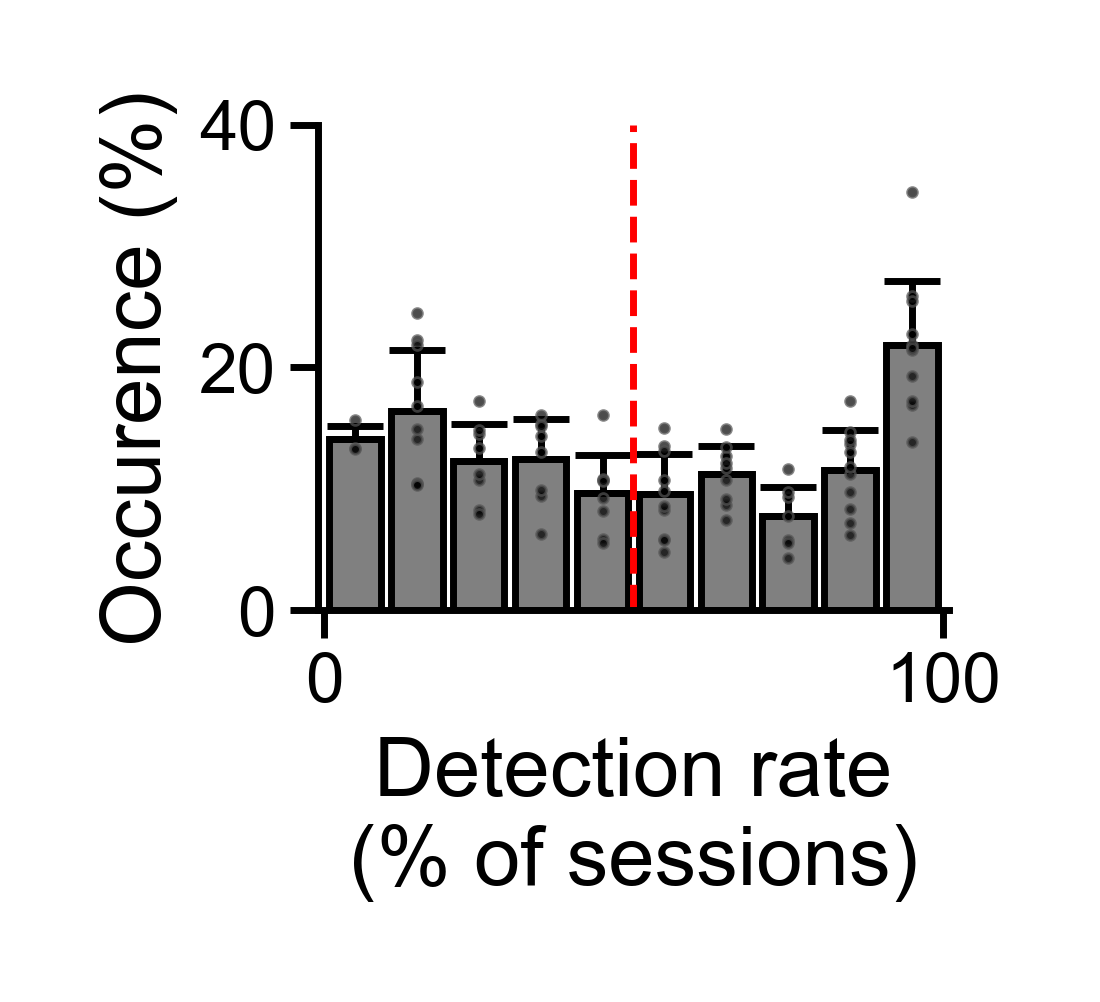

In [7]:
plt.style.use(styles('publication-tight'))
# plot
axs = plt.figure(figsize=(25/25.4 ,22.5/25.4),dpi=1000,layout="constrained").subplot_mosaic(
    [
        ['plot'],
    ],
    empty_sentinel="BLANK",
    # set the height ratios between the rows
    height_ratios=[1,],
    # set the width ratios between the columns
    width_ratios=[1],
)
ax = axs['plot']
x_pos = np.arange(0+(bin_size/2), 100,bin_size)
ax.bar(x_pos, result_m,width=bin_size/1.2, color='gray',edgecolor='black',linewidth=0.5)
y_err = np.array([ [0,err] for err in result_std]).T
ax.errorbar(x_pos,result_m,
           yerr = y_err,fmt='none',solid_capstyle='projecting',
            capsize=2,color='black',capthick=0.5,elinewidth=0.5)
plt.axvline(x=50,color='red',linestyle='--',marker='')
ax.set_xlim(-1,101)
ax.set_xlabel('Detection rate\n(% of sessions)')
ax.set_ylabel('Occurence (%)')
# plot individual result animals as scatter.
for i,animal in enumerate(animals):
    y = result[i]
    x = np.arange(0,100,bin_size)
    x = x + (bin_size/2)
    ax.scatter(x,y,marker='o', s=0.5, c='black', alpha=0.7, edgecolor='#555555', linewidth=0.2, zorder=1000)